<a href="https://colab.research.google.com/github/maxsolomonhenry/mlp/blob/master/MLP_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Todo:
#       dropout w/ probability.
#       shuffle input X.

import torch


class TwoLayerMLP:
    def __init__(self, n_iter=1000, learning_rate=0.1, batch_size=30, hidden_layer_width=100,
                 hidden_activation='relu'):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.hidden_layer_width = hidden_layer_width
        self.hidden_activation = hidden_activation
        self.V = torch.tensor([])
        self.W = torch.tensor([])
        self.inputs = torch.tensor([])
        self.labels = torch.tensor([])
        self.X = torch.tensor([])
        self.Y = torch.tensor([])
        self.Y_hat = torch.tensor([])
        self.A1 = torch.tensor([])
        self.Z1 = torch.tensor([])
        self.Z2 = torch.tensor([])

    @staticmethod
    def hyperbolic_tangent(Z):
        return Z.tanh()

    @staticmethod
    def hyperbolic_tangent_derivative(Z):
        return 1 - Z.tanh() ** 2

    @staticmethod
    def sigmoid(Z):
        return 1 / (1 + torch.exp(-Z))

    @staticmethod
    def relu(Z):
        return torch.clamp(Z, min=0)

    @staticmethod
    def relu_subgradient(Z):
        return torch.clamp(torch.sign(Z), min=0)

    @staticmethod
    def softmax(Z):
        # Transposing is to allow for row-wise operations (with built-in broadcasting)
        max_dim = 1
        if Z.ndim == 1:
            max_dim = 0
        Z0_transpose = Z.t() - Z.max(max_dim)[0]
        Y_hat_transpose = torch.exp(Z0_transpose)
        Y_hat_transpose /= Y_hat_transpose.sum(0)
        Y_hat = Y_hat_transpose.t()
        return Y_hat

    @staticmethod
    def cross_entropy_loss(y_hat, y):
        return -torch.dot(y, torch.log(y_hat))

    @staticmethod
    def cross_entropy_grad(y_hat, y):
        return -(y * 1 / y_hat) + (1 - y) * (1 / (1 - y_hat))

    @staticmethod
    def tensor_width(tensor):
        if len(list(tensor.shape)) == 2:
            return tensor.size(1)
        elif len(list(tensor.shape)) == 1:
            return 1
        else:
            raise ValueError('Tensor must be one or two dimensions.')

    @staticmethod
    def matrixify(y):
        num_categories = int(y.max()) + 1
        num_entries = len(y)
        y = y.long()
        Y = torch.zeros(num_entries, num_categories)
        for i in range(num_entries):
            Y[i, y[i]] = 1
        return Y

    def sigmoid_derivative(self, Z):
        return self.sigmoid(Z) * (1 - self.sigmoid(Z))

    def softmax_grad(self, Z):
        # This code adapted from https://link.medium.com/OgOkKMjCz5
        soft_max_result = self.softmax(Z)
        reshaped = soft_max_result.view(-1, 1)
        return torch.diagflat(reshaped) - torch.ger(reshaped[:, 0], reshaped[:, 0])

    def activation(self, Z, output=False, derivative=False):
        if not output:
            function = self.hidden_activation
        else:
            function = 'softmax'

        if not derivative:
            if function == 'relu':
                return self.relu(Z)
            elif function == 'tanh':
                return self.hyperbolic_tangent(Z)
            elif function == 'sigmoid':
                return self.sigmoid(Z)
            elif function == 'softmax':
                return self.softmax(Z)
            else:
                raise ValueError("Invalid activation function.")
        else:
            if function == 'relu':
                return self.relu_subgradient(Z)
            elif function == 'tanh':
                return self.hyperbolic_tangent_derivative(Z)
            elif function == 'sigmoid':
                return self.sigmoid_derivative(Z)
            elif function == 'softmax':
                return self.softmax_grad(Z)
            else:
                raise ValueError("Invalid activation function.")

    def verify_args(self):
        if self.batch_size > self.inputs.size(0):
            raise ValueError('Mini-batch size cannot be larger than data set.')

    def initialize_weights(self):
        num_categories = self.tensor_width(self.labels)
        num_features = self.inputs.size(1)
        self.W = torch.normal(0., 1., [num_features, self.hidden_layer_width])
        self.W = self.W.to(self.device)
        self.V = torch.normal(0., 1., [self.hidden_layer_width, num_categories])
        self.V = self.V.to(self.device)

    def set_ith_batch(self, i):
        """Selects a mini-batch of samples allowing for wraparound.
        """

        first_sample = i * self.batch_size % self.labels.size(0)

        if self.batch_size <= (self.inputs.size(0) - first_sample):
            self.X = self.inputs[first_sample:first_sample + self.batch_size, :]
            self.Y = self.labels[first_sample:first_sample + self.batch_size, :]
        else:
            input_end = self.inputs[first_sample:, :]
            label_end = self.labels[first_sample:, :]
            input_wraparound = self.inputs[:(self.batch_size - len(input_end)), :]
            label_wraparound = self.labels[:(self.batch_size - len(label_end)), :]
            self.X = torch.cat((input_end, input_wraparound))
            self.Y = torch.cat((label_end, label_wraparound))
        self.X = self.X.to(self.device)
        self.Y = self.Y.to(self.device)

    def predict_one_batch(self):
        # N = number of instances in mini batch
        # M = number of hidden units
        # C = number of output categories
        self.Z1 = torch.mm(self.X, self.W)  # (N x D) x (D x M) -> (N x M)
        self.A1 = self.activation(self.Z1)
        self.Z2 = torch.mm(self.A1, self.V)  # (N x M) x (M x C) -> (N x C)
        self.Y_hat = self.activation(self.Z2, output=True)

    def train_one_batch(self):
        self.predict_one_batch()
        delta_V = 0
        delta_W = 0
        for i in range(self.batch_size):
            # Accumulate gradients for W and V.
            loss_and_softmax_grad = self.Y_hat[i, :] - self.Y[i, :]
            delta_V += torch.ger(self.A1[i, :], loss_and_softmax_grad)
            row_calculation = torch.mv(self.V, loss_and_softmax_grad) * self.activation(self.Z1[i, :], derivative=True)
            delta_W += torch.ger(self.X[i, :], row_calculation)
        # Average gradients.
        delta_V /= self.batch_size
        delta_W /= self.batch_size
        # Gradient descent.
        self.V -= self.learning_rate * delta_V
        self.W -= self.learning_rate * delta_W

    def train(self, inputs, labels):
        self.inputs = inputs
        self.inputs = self.inputs.to(self.device)
        self.labels = self.matrixify(labels)
        self.labels = self.labels.to(self.device)
        self.verify_args()
        self.initialize_weights()
        for i in range(self.n_iter):
            self.set_ith_batch(i)
            self.train_one_batch()

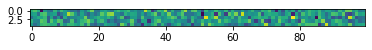

In [16]:
import matplotlib.pyplot as plt

mlp = TwoLayerMLP(hidden_activation='relu', n_iter=1000, batch_size=30)

num_features = 5
num_samples = 300
num_labels = 4

inputs = torch.rand(num_samples, num_features)
labels = (torch.rand(num_samples) * (num_labels - 1)).round()
mlp.train(inputs, labels)

plt.imshow(mlp.W.to('cpu'))
plt.show()